In [1]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from sklearn.metrics import accuracy_score
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import gensim.downloader
from gensim.models import Word2Vec
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import CountVectorizer
import re
import ast
from nltk.stem import PorterStemmer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import json

#data_path = "data/html/*.html"
data_path = "/content/drive/MyDrive/CS412_Course-Project/dataset/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
count = 0
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:

        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # Find the script tag with id="__NEXT_DATA__" and type="application/json"
        script_tag = soup.find('script', id='__NEXT_DATA__', type='application/json')

        #print(str(script_tag.string))
        data = json.loads(str(script_tag.string))

        # print("\n", data['props']['pageProps']["sharedConversationId"], "\n")

        try:
            mapping = data['props']['pageProps']['serverResponse']['data']['mapping']
            # Rest of the code that uses 'mapping'
        except KeyError as e:
            print(f"Error: {e}. Skipping this iteration.")
            continue

        messages = []
        for key , value in mapping.items():
          message = value.get("message")
          if message != None:
            role = message.get("author").get("role")
            if role == "user" or role == "assistant" and message != None:
              messages.append(message)

        convo_texts = []
        for message in messages:
            #print(message.items())
            role = message.get("author").get("role")
            create_time = message.get("create_time")
            content = message.get("content").get("parts")
            if content != None:
              content = '\n'.join(content)

              if role == "assistant":
                pattern = "```python(.*?)```"
                python_code = re.findall(pattern, content, re.DOTALL)

                convo_texts.append({
                    "role": role,
                    "text" : content,
                    "create_time": create_time,
                    "python_code" : "\n".join(python_code)
                })

              else:
                convo_texts.append({
                    "role": role,
                    "text" : content,
                    "create_time": create_time
                })

        code2convos[file_code] = convo_texts
    # count += 1
    # if count == 2:
    #   break

 13%|█▎        | 16/127 [00:04<00:14,  7.61it/s]

Error: 'serverResponse'. Skipping this iteration.


 45%|████▍     | 57/127 [00:09<00:07,  8.96it/s]

Error: 'serverResponse'. Skipping this iteration.


 74%|███████▍  | 94/127 [00:18<00:07,  4.36it/s]

Error: 'serverResponse'. Skipping this iteration.


 86%|████████▌ | 109/127 [00:20<00:02,  7.66it/s]

Error: 'serverResponse'. Skipping this iteration.


100%|██████████| 127/127 [00:23<00:00,  5.44it/s]


In [4]:

for code, messages in code2convos.items():
  sorted_messages = sorted(messages, key=lambda x: x['create_time'])
  code2convos[code] = sorted_messages


In [5]:
# let's see one of the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'create_time': 1701015129.610132,
 'role': 'user',
 'text': 'Load a CSV file into a Pandas in Python. The file is named '
         "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
         "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
         "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
         "'Health Metrics'. \n"}


#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [6]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts

In [7]:
prompts[0]

"Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. \n"

In [8]:
len(prompts)

3544

In [9]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

In [10]:
def preprocess_text(text):
    """
    Preprocesses the input text using NLTK.

    Parameters:
    - text (str): Input text to be preprocessed.

    Returns:
    - list: Preprocessed tokens.
    """

    # Tokenization
    tokens = word_tokenize(text)

    # Convert to lowercase
    tokens = [word.lower() for word in tokens]

    # Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    stripped = [word.translate(table) for word in tokens]

    # Remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]

    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    return words


# Apply preprocessing to each string in the list
preprocessed_prompts = [preprocess_text(text) for text in prompts]
preprocessed_questions = [preprocess_text(text) for text in questions]

# Join each inner list into a single string
preprocessed_prompts = [' '.join(inner_list) for inner_list in preprocessed_prompts]
preprocessed_questions = [' '.join(inner_list) for inner_list in preprocessed_questions]

In [11]:
print(preprocessed_prompts[0])
print(preprocessed_questions[0])

load csv file panda python file name contain column like speci island sex diet year life stage bodi mass g bill length mm bill depth mm flipper length mm health metric
initi first make copi notebook given starter make sure choos connect form upper right may upload data section left colab right click csv file get path file click copi path use load data


In [12]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(preprocessed_prompts + preprocessed_questions)

In [13]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF.head()

,aall,aani,ab,abciter,abcseri,abil,abiout,abl,abov,absolut,...,ytrainpr,ytrainrootsplit,ytrainshap,ytrainuniqu,yvalu,zaman,zero,zerodivisionerror,zeroth,zip
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
code2prompts_tf_idf = dict()
for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

In [15]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"]

,aall,aani,ab,abciter,abcseri,abil,abiout,abl,abov,absolut,...,ytrainpr,ytrainrootsplit,ytrainshap,ytrainuniqu,yvalu,zaman,zero,zerodivisionerror,zeroth,zip
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 3222)

In [17]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [18]:
questions[4]

"Features and Correlations (10 pts)\n\n* Correlations of features with health (4 points)\nCalculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.\n\n* Feature Selection (3 points)\nSelect a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.\n\n* Hypothetical Driver Features (3 points)\nPropose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.\n\n* __Note:__ You get can get help from GPT.\n"

In [19]:
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.130553,0.380344,0.651510,0.394845,0.378548,0.658620,0.067698,0.181043,0.190275
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.234486,0.801447,0.905214,0.664319,0.559980,0.985824,0.852034,0.730450,0.737933
2,041f950b-c013-409a-a642-cffff60b9d4b,0.100638,0.193792,0.476585,0.252662,0.474933,0.257311,0.446774,0.654083,0.203436
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.105714,0.142203,0.329939,0.475956,0.423545,0.499110,0.390443,0.310438,0.536305
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.435297,0.674815,0.884469,0.652362,0.585796,0.820510,0.620594,0.921575,0.705270
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.112101,0.189462,0.206061,0.458198,0.360116,0.369264,1.000000,0.909195,0.919604
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.165954,0.278976,0.470478,0.860247,0.724190,0.963783,0.349775,0.855911,0.737933
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.187928,1.000000,1.000000,0.859942,0.845989,0.874324,0.728059,0.915740,0.609410
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.187928,1.000000,1.000000,0.565047,0.845989,0.945932,1.000000,1.000000,0.889775


# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [20]:
def analyze_sentiment_vader(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(text)

    if sentiment['compound'] >= 0.05:
        return 1
    elif sentiment['compound'] <= -0.05:
        return -1
    else:
        return 0

analyze_sentiment_vader("Hello please")

1

In [21]:
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "thank", "next", "Entropy"]
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    prevText = "Null"
    prevTime = convs[0].get("create_time")
    conv_time_intervals = []
    python_code = ""

    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":

            # count the user prompts
            code2features[code]["#user_prompts"] += 1

            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            # analyse sentiment
            sent = analyze_sentiment_vader(text)
            if sent == 1:
              code2features[code]["#positive_prompt"] +=1
            elif sent == -1:
              code2features[code]["#negative_prompt"] +=1

            #check promt similarity
            if prevText != "Null":
              vectorizer = CountVectorizer().fit_transform([text, prevText])
              vectors = vectorizer.toarray()
              cosine_sim = cosine_similarity(vectors)
              code2features[code]["promt_similarity"] += cosine_sim[0][1]

            code2features[code]["prompt_avg_chars"] += len(text)
            prevText = text

            #check time intervals between user prompts
            conv_time_intervals.append(c.get("create_time") - prevTime)
            prevTime = c.get("create_time")

        else:
            python_code += ('\n' + c["python_code"])

            code2features[code]["response_avg_chars"] += len(text)
            prevText = text


    function_count = len(re.findall(r'\bdef\b', python_code))  # Count 'def' as an indicator of a function
    loop_count = len(re.findall(r'\bfor\b|\bwhile\b', python_code))


    total_time = 0
    for interval in conv_time_intervals:
      total_time += interval
    code2features[code]["total_time"] = total_time
    code2features[code]["average_time"] = total_time / len(conv_time_intervals)

    code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]
    code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]
    code2features[code]["promt_similarity"] /= code2features[code]["#user_prompts"]


In [22]:
df = pd.DataFrame(code2features).T
min_value = df['promt_similarity'].min()
max_value = df['promt_similarity'].max()

# Normalize the 'A' column using Min-Max scaling
df['promt_similarity'] = (df['promt_similarity'] - min_value) / (max_value - min_value)
df.head(5)

,#user_prompts,#error,#no,#thank,#next,#entropy,#positive_prompt,prompt_avg_chars,response_avg_chars,promt_similarity,#negative_prompt,total_time,average_time
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,9.0,407.214286,2252.214286,1.000000,2.0,3740.183183,267.155942
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,10.0,261.111111,1677.166667,0.820281,1.0,5931.260760,329.514487
041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,3.0,663.000000,1657.000000,0.369471,4.0,28729.104035,3192.122671
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,12.0,114.100000,1795.550000,0.535539,2.0,158752.612194,7937.630610
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,32.0,217.081395,1474.848837,0.664835,10.0,672175.313043,7815.992012


In [23]:
# reading the scores
scores = pd.read_csv("/content/drive/MyDrive/CS412_Course-Project/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


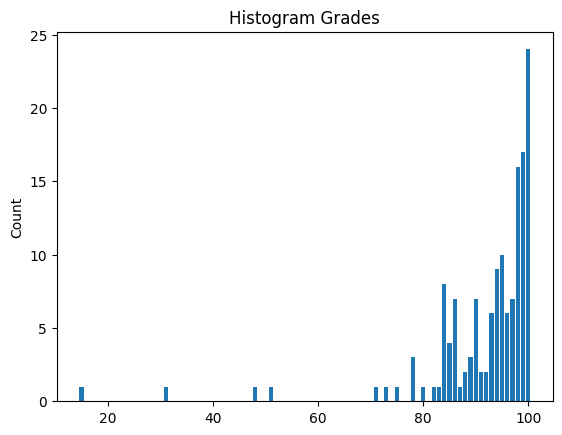

In [24]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [25]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#positive_prompt,prompt_avg_chars,response_avg_chars,promt_similarity,#negative_prompt,total_time,average_time
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,9.0,407.214286,2252.214286,1.000000,2.0,3740.183183,267.155942
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,10.0,261.111111,1677.166667,0.820281,1.0,5931.260760,329.514487
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,3.0,663.000000,1657.000000,0.369471,4.0,28729.104035,3192.122671
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,12.0,114.100000,1795.550000,0.535539,2.0,158752.612194,7937.630610
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,32.0,217.081395,1474.848837,0.664835,10.0,672175.313043,7815.992012


In [26]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#positive_prompt,prompt_avg_chars,response_avg_chars,...,average_time,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,9.0,407.214286,2252.214286,...,267.155942,0.130553,0.380344,0.651510,0.394845,0.378548,0.658620,0.067698,0.181043,0.190275
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,10.0,261.111111,1677.166667,...,329.514487,0.234486,0.801447,0.905214,0.664319,0.559980,0.985824,0.852034,0.730450,0.737933
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,3.0,663.000000,1657.000000,...,3192.122671,0.100638,0.193792,0.476585,0.252662,0.474933,0.257311,0.446774,0.654083,0.203436
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,12.0,114.100000,1795.550000,...,7937.630610,0.105714,0.142203,0.329939,0.475956,0.423545,0.499110,0.390443,0.310438,0.536305
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,32.0,217.081395,1474.848837,...,7815.992012,0.435297,0.674815,0.884469,0.652362,0.585796,0.820510,0.620594,0.921575,0.705270


#### Merging scores with features

In [27]:
temp_df = pd.merge(df, scores, on='code', how="left")
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code", inplace=True, keep="first")
temp_df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#positive_prompt,prompt_avg_chars,response_avg_chars,...,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,9.0,407.214286,2252.214286,...,0.130553,0.380344,0.651510,0.394845,0.378548,0.658620,0.067698,0.181043,0.190275,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,10.0,261.111111,1677.166667,...,0.234486,0.801447,0.905214,0.664319,0.559980,0.985824,0.852034,0.730450,0.737933,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,3.0,663.000000,1657.000000,...,0.100638,0.193792,0.476585,0.252662,0.474933,0.257311,0.446774,0.654083,0.203436,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,12.0,114.100000,1795.550000,...,0.105714,0.142203,0.329939,0.475956,0.423545,0.499110,0.390443,0.310438,0.536305,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,32.0,217.081395,1474.848837,...,0.435297,0.674815,0.884469,0.652362,0.585796,0.820510,0.620594,0.921575,0.705270,100.0


In [28]:
#Remove outlier datas
temp_df = temp_df[temp_df['grade'] > 60]

In [29]:
X = temp_df[temp_df.columns[ :-1]]
y = temp_df[["code", "grade"]]


#### Train/Test split

In [30]:
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train set size:", len(X_train_df))
print("Test set size:", len(X_test_df))

Train set size: 83
Test set size: 21


In [31]:
temp_df.columns[1:-1]

Index(['#user_prompts', '#error', '#no', '#thank', '#next', '#entropy',
       '#positive_prompt', 'prompt_avg_chars', 'response_avg_chars',
       'promt_similarity', '#negative_prompt', 'total_time', 'average_time',
       'Q_0', 'Q_1', 'Q_2', 'Q_3', 'Q_4', 'Q_5', 'Q_6', 'Q_7', 'Q_8'],
      dtype='object')

In [32]:
temp_df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#positive_prompt,prompt_avg_chars,response_avg_chars,...,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,grade
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,10.0,261.111111,1677.166667,...,0.234486,0.801447,0.905214,0.664319,0.559980,0.985824,0.852034,0.730450,0.737933,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,3.0,663.000000,1657.000000,...,0.100638,0.193792,0.476585,0.252662,0.474933,0.257311,0.446774,0.654083,0.203436,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,12.0,114.100000,1795.550000,...,0.105714,0.142203,0.329939,0.475956,0.423545,0.499110,0.390443,0.310438,0.536305,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,32.0,217.081395,1474.848837,...,0.435297,0.674815,0.884469,0.652362,0.585796,0.820510,0.620594,0.921575,0.705270,100.0
5,090d6217-5d69-4929-a342-19abab78324f,73.0,13.0,0.0,0.0,0.0,19.0,20.0,300.191781,1483.397260,...,0.203034,0.693947,0.755535,0.652362,0.585796,0.820510,0.681889,0.818385,1.000000,84.0


In [33]:
def jaccard_similarity(code1, code2):
  tokens1 = set(code1.split())
  tokens2 = set(code2.split())

  intersection = len(tokens1.intersection(tokens2))
  union = len(tokens1.union(tokens2))

  jaccard_similarity = intersection / union
  return jaccard_similarity

# New feature addition for code similarty to perfect codes
perfect_codes = []
for index, row in y_train_df.iterrows():
  if row["grade"] == 100:
    python_code = ""
    for message in code2convos[row["code"]]:
      if message.get("role") == "assistant":
        python_code += ("\n" + message.get("python_code"))
    perfect_codes.append(python_code)

avg_similarity = 0
avg_pycode_sim = []
for index, row in X_train_df.iterrows():
  python_code = ""
  for message in code2convos[row["code"]]:
    if message.get("role") == "assistant":
      python_code += ("\n" + message.get("python_code"))

  for pycode in perfect_codes:
    avg_similarity += jaccard_similarity(python_code, pycode)

  avg_similarity /= len(perfect_codes)
  avg_pycode_sim.append(avg_similarity)

X_train_df["avg_pycode_sim"] = avg_pycode_sim



avg_similarity = 0
avg_pycode_sim = []
for index, row in X_test_df.iterrows():
  python_code = ""
  for message in code2convos[row["code"]]:
    if message.get("role") == "assistant":
      python_code += ("\n" + message.get("python_code"))

  for pycode in perfect_codes:
    avg_similarity += jaccard_similarity(python_code, pycode)

  avg_similarity /= len(perfect_codes)
  avg_pycode_sim.append(avg_similarity)

X_test_df["avg_pycode_sim"] = avg_pycode_sim

In [34]:
X_train = X_train_df[X_train_df.columns[1:]].to_numpy()
X_test = X_test_df[X_test_df.columns[1:]].to_numpy()
y_train = y_train_df["grade"].to_numpy()
y_test = y_test_df["grade"].to_numpy()


#### Fitting a model

#### Predicting and Analyzing

# **LINEAR REGRESSION**

In [35]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)

print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred)}")
print(f"R^2 Score: {r2_score(y_test, y_pred)}")

Mean Squared Error (MSE): 42.06577886652334
R^2 Score: -0.7211921024435699


# **DECISION TREE**

In [36]:
score_dict = {}

for i in range(1,21):
  regressor = DecisionTreeRegressor(random_state=0,criterion='squared_error', max_depth=i)
  regressor.fit(X_train, y_train)

  # Prediction
  y_train_pred = regressor.predict(X_train)
  y_test_pred = regressor.predict(X_test)

  score_dict[i] = mean_squared_error(y_test,y_test_pred)

min_mse_depth = min(score_dict, key=score_dict.get)
print("Min MSE is observed at depth:", min_mse_depth, "with MSE:", score_dict[min_mse_depth])

Min MSE is observed at depth: 1 with MSE: 29.173505952380953


In [37]:
regressor = DecisionTreeRegressor(random_state=0,criterion='squared_error', max_depth=min_mse_depth)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1, random_state=0)

In [38]:
extracted_MSEs = regressor.tree_.impurity
for idx, MSE in enumerate(regressor.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))

Node 0 has MSE 39.28872114965998
Node 1 has MSE 64.609375
Node 2 has MSE 25.438933333334717


In [39]:
# Plotting the Tree
dot_data = tree.export_graphviz(regressor, out_file=None, feature_names=X_train_df.columns[1: ])
graph = graphviz.Source(dot_data)
graph.render("hw")

'hw.pdf'

In [40]:
# DECISION TREE REGRESSION WITH BAGGING + BOOSTING

# Create the base decision tree regressor
bregressor = DecisionTreeRegressor(random_state=42, criterion='squared_error', max_depth=5)

# Create the boosting regressor
boosting_regressor = AdaBoostRegressor(bregressor, n_estimators=50, random_state=42)

# Concatenate the training and test sets for cross-validation
X_combined = np.concatenate((X_train, X_test), axis=0)
y_combined = np.concatenate((y_train, y_test), axis=0)

# Perform cross-validation
cv_scores = cross_val_score(boosting_regressor, X_combined, y_combined, cv=5, scoring='neg_mean_squared_error')

# Fit the boosting regressor on the entire training set
boosting_regressor.fit(X_train, y_train)

# Prediction
y_train_pred = boosting_regressor.predict(X_train)
y_test_pred = boosting_regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train, y_train_pred))
print("MSE TEST:", mean_squared_error(y_test, y_test_pred))

# Print cross-validation scores
print("Cross-Validation MSE Scores:", -cv_scores)  # The negation is used because cross_val_score returns negated values

# Print mean cross-validation MSE
print("Mean Cross-Validation MSE:", -np.mean(cv_scores))

print("R2 Train:", r2_score(y_train, y_train_pred))
print("R2 TEST:", r2_score(y_test, y_test_pred))


MSE Train: 1.5200024690480896
MSE TEST: 29.919491643613316
Cross-Validation MSE Scores: [37.01232678 44.10375644 37.68479548 20.10852616 26.21030428]
Mean Cross-Validation MSE: 33.02394182800461
R2 Train: 0.9613119891772989
R2 TEST: -0.2242063290808567


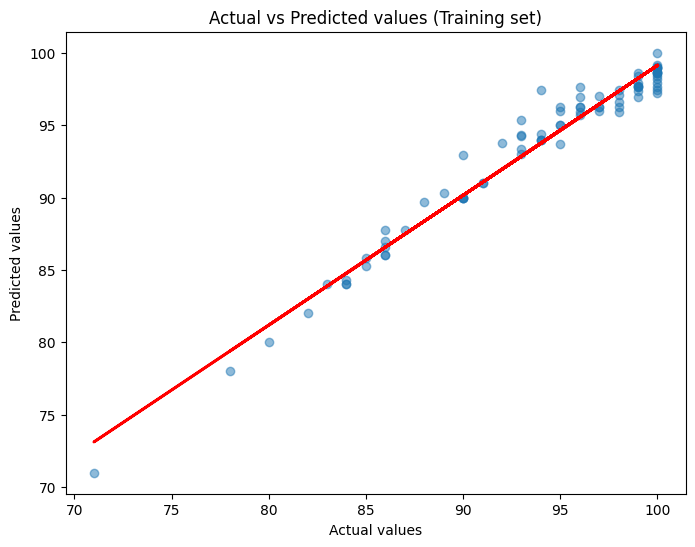

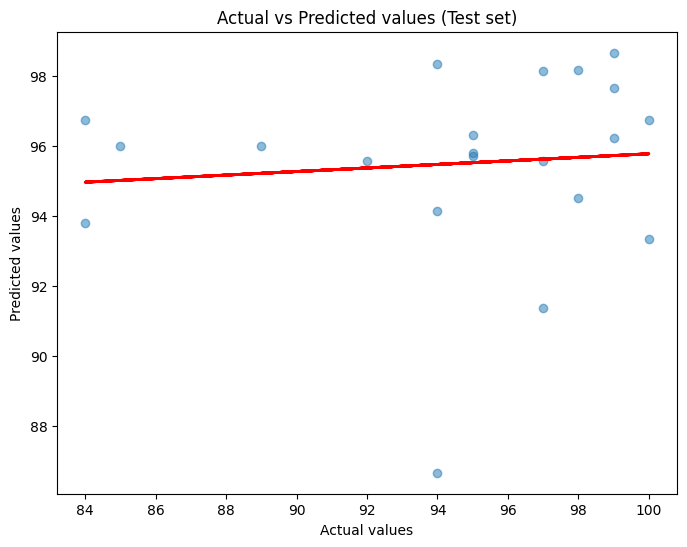

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import _tree

# Function to plot actual vs predicted values
def plot_actual_vs_predicted(y_actual, y_predicted, set_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_actual, y_predicted, alpha=.5)
    plt.title(f"Actual vs Predicted values ({set_name} set)")
    plt.xlabel("Actual values")
    plt.ylabel("Predicted values")

    # Add a line of best fit
    fit = np.polyfit(y_actual, y_predicted, 1)
    line = np.poly1d(fit)
    plt.plot(y_actual, line(y_actual), color='red', linewidth=2)
    plt.show()

# Function to plot feature importances
def plot_feature_importances(model, feature_names):
    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()[::-1]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importances[sorted_idx], y=np.array(feature_names)[sorted_idx])
    plt.title("Feature Importances")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()

# Plot actual vs predicted values for training set
plot_actual_vs_predicted(y_train, y_train_pred, "Training")

# Plot actual vs predicted values for test set
plot_actual_vs_predicted(y_test, y_test_pred, "Test")

# Plot feature importances
feature_names = [str(i) for i in range(X_train.shape[1])]
if isinstance(boosting_regressor, DecisionTreeRegressor):
    plot_feature_importances(boosting_regressor, feature_names=feature_names)


# **RANDOM FOREST**

In [42]:
# RANDOM FOREST

from sklearn.ensemble import RandomForestRegressor

# Create the random forest regressor with hyperparameter tuning
rf_regressor = RandomForestRegressor(n_estimators=36, max_depth=5, random_state=42)

# Concatenate the training and test sets for cross-validation
X_combined = np.concatenate((X_train, X_test), axis=0)
y_combined = np.concatenate((y_train, y_test), axis=0)

# Perform cross-validation with Random Forest
cv_scores_rf = cross_val_score(rf_regressor, X_combined, y_combined, cv=5, scoring='neg_mean_squared_error')

# Fit the random forest regressor on the entire training set
rf_regressor.fit(X_train, y_train)

# Prediction with Random Forest
y_train_pred_rf = rf_regressor.predict(X_train)
y_test_pred_rf = rf_regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE) for Random Forest
print("Random Forest MSE Train:", mean_squared_error(y_train, y_train_pred_rf))
print("Random Forest MSE TEST:", mean_squared_error(y_test, y_test_pred_rf))

# Print cross-validation scores for Random Forest
print("Random Forest Cross-Validation MSE Scores:", -cv_scores_rf)

# Print mean cross-validation MSE for Random Forest
print("Random Forest Mean Cross-Validation MSE:", -np.mean(cv_scores_rf))

# Print R2 scores for Random Forest
print("Random Forest R2 Train:", r2_score(y_train, y_train_pred_rf))
print("Random Forest R2 TEST:", r2_score(y_test, y_test_pred_rf))


Random Forest MSE Train: 7.71435744182537
Random Forest MSE TEST: 32.80217592873987
Random Forest Cross-Validation MSE Scores: [42.11779547 45.15653348 30.46029377 24.72288557 29.80677462]
Random Forest Mean Cross-Validation MSE: 34.45285658246906
Random Forest R2 Train: 0.8036495661836438
Random Forest R2 TEST: -0.3421562056572911


In [43]:
[str(i) for i in temp_df.columns[1:-1]]

['#user_prompts',
 '#error',
 '#no',
 '#thank',
 '#next',
 '#entropy',
 '#positive_prompt',
 'prompt_avg_chars',
 'response_avg_chars',
 'promt_similarity',
 '#negative_prompt',
 'total_time',
 'average_time',
 'Q_0',
 'Q_1',
 'Q_2',
 'Q_3',
 'Q_4',
 'Q_5',
 'Q_6',
 'Q_7',
 'Q_8']

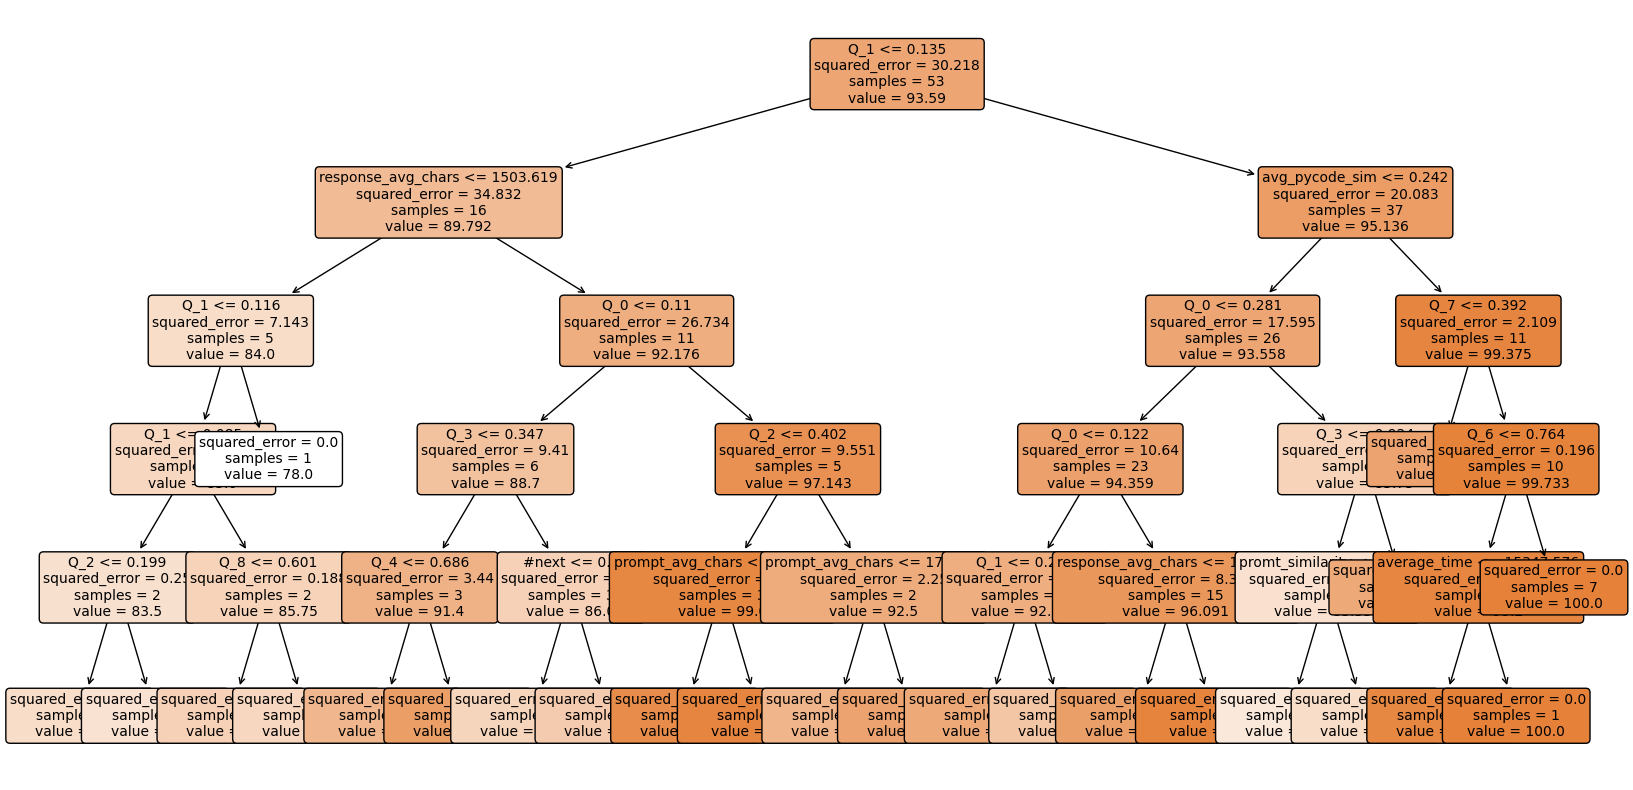

In [44]:
# EXPORT THE TREE GRAPH OF THE FOREST AS PDF

from sklearn.tree import export_graphviz
import graphviz

feature_names = [str(i) for i in X_train_df.columns[1:]]

# Choose a tree index (e.g., 0 for the first tree)
tree_index = 0

# Export the chosen tree to a DOT file
dot_data = export_graphviz(rf_regressor.estimators_[tree_index], out_file=None,
                           feature_names=feature_names,
                           filled=True, rounded=True, special_characters=True)

# Create a graph from the DOT data
graph = graphviz.Source(dot_data)

# Save the graph as a PDF file
graph.render("random_forest_tree")

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(rf_regressor.estimators_[tree_index], feature_names=feature_names, filled=True, rounded=True, fontsize=10)
plt.show()

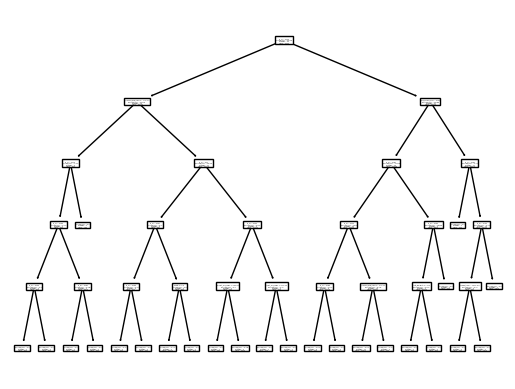

In [45]:
# 3D REPRESENTATION OF THE GRAPH

import plotly.express as px
from sklearn import tree

num_features = X_train.shape[1]  # Get the number of features (columns)

# Use sentiment analysis tags for axis (0: user_prompts, 6: positive_prompts, 10:negative_prompts)
fig = px.scatter_3d(X_train, x=0, y=6, z=10, color=y_train)

fig.update_layout(scene=dict(aspectmode="cube"))
tree.plot_tree(rf_regressor.estimators_[tree_index], feature_names=feature_names)
fig.show()


Bagging + Random Forest MSE Train: 12.816352168709466
Bagging + Random Forest MSE TEST: 28.883628221503447



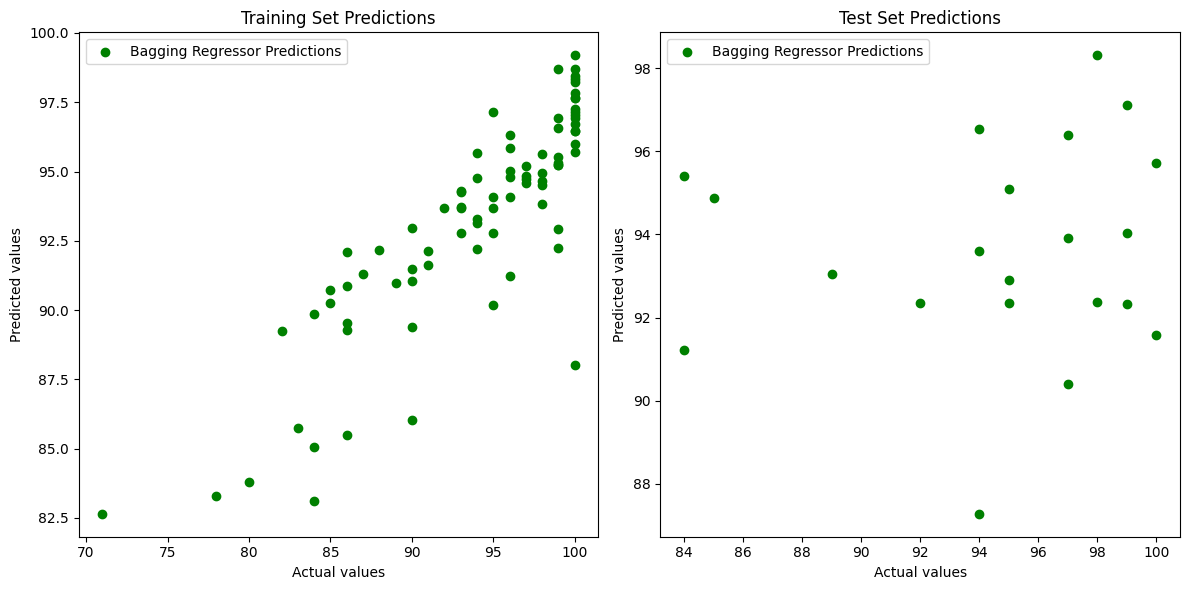

In [46]:
# RANDOM FOREST + BAGGING IMPLEMENTATION

# Import necessary libraries for bagging and boosting
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

# Bagging with Random Forest
bagging_rf_regressor = BaggingRegressor(estimator=RandomForestRegressor(n_estimators=36, max_depth=5, random_state=42)
                                    , n_estimators=4, random_state=42)

# Fit the bagging regressor on the entire training set
bagging_rf_regressor.fit(X_train, y_train)

# Prediction with Bagging and Random Forest
y_train_pred_bagging_rf = bagging_rf_regressor.predict(X_train)
y_test_pred_bagging_rf = bagging_rf_regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE) for Bagging and Random Forest
print("Bagging + Random Forest MSE Train:", mean_squared_error(y_train, y_train_pred_bagging_rf))
print("Bagging + Random Forest MSE TEST:", mean_squared_error(y_test, y_test_pred_bagging_rf))
print()

# Visualize predictions on the training set
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred_bagging_rf, c='green', label='Bagging Regressor Predictions')
plt.title('Training Set Predictions')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.legend()

# Visualize predictions on the test set
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_bagging_rf, c='green', label='Bagging Regressor Predictions')
plt.title('Test Set Predictions')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.legend()

plt.tight_layout()
plt.show()

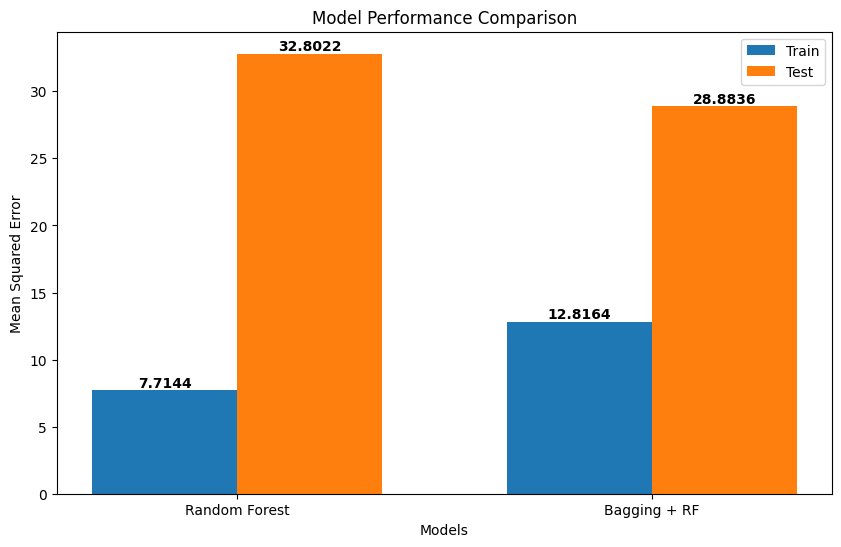

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

mse_rf_train = mean_squared_error(y_train, rf_regressor.predict(X_train))
mse_rf_test = mean_squared_error(y_test, rf_regressor.predict(X_test))
mse_bagging_train = mean_squared_error(y_train, y_train_pred_bagging_rf)
mse_bagging_test = mean_squared_error(y_test, y_test_pred_bagging_rf)

labels = ['Random Forest', 'Bagging + RF']
train_values = [mse_rf_train, mse_bagging_train]
test_values = [mse_rf_test, mse_bagging_test]

bar_width = 0.35
index = np.arange(len(labels))

# Set a larger figure size
plt.figure(figsize=(10, 6))

# Plotting training values
plt.bar(index, train_values, bar_width, label='Train')
# Plotting test values with an offset
plt.bar(index + bar_width, test_values, bar_width, label='Test')

plt.xlabel('Models')
plt.ylabel('Mean Squared Error')
plt.title('Model Performance Comparison')
plt.xticks(index + bar_width / 2, labels)
plt.legend()

# Annotate each bar with its height (bold text)
for i, train_value, test_value in zip(index, train_values, test_values):
    plt.text(i, train_value + 0.01, f'{round(train_value, 4)}', ha='center', va='bottom', fontweight='bold', color='black')
    plt.text(i + bar_width, test_value + 0.01, f'{round(test_value, 4)}', ha='center', va='bottom', fontweight='bold', color='black')

plt.show()


# **SVM**

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Create SVR model
svm_regressor = SVR(kernel='poly', C=2.0)

# Train the model
svm_regressor.fit(X_train, y_train)

# Make predictions on training and testing sets
y_train_pred = svm_regressor.predict(X_train)
y_test_pred = svm_regressor.predict(X_test)

# Calculate MSE scores
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Print MSE scores
print(f'Mean Squared Error (MSE) on Training Data: {mse_train}')
print(f'Mean Squared Error (MSE) on Test Data: {mse_test}')


Mean Squared Error (MSE) on Training Data: 43.05049014646584
Mean Squared Error (MSE) on Test Data: 27.19934576810092


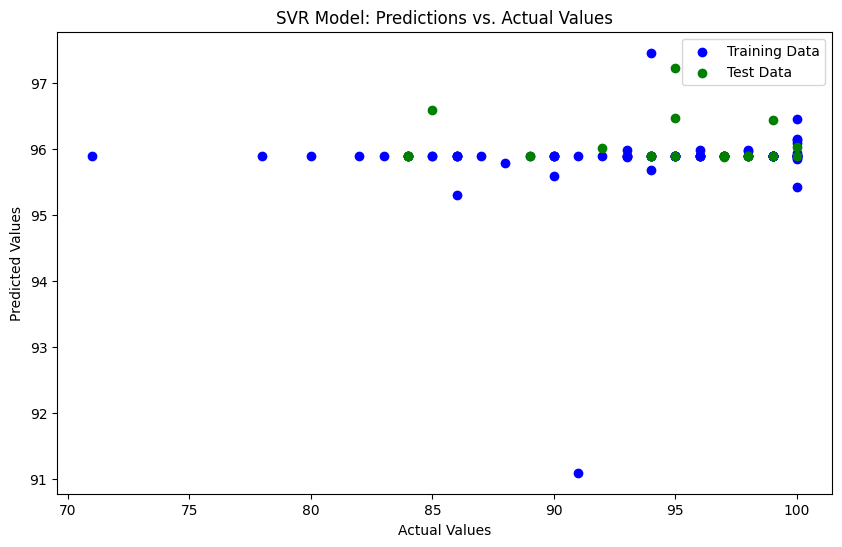

In [49]:
plt.figure(figsize=(10, 6))

# Training set
plt.scatter(y_train, y_train_pred, color='blue', label='Training Data')

# Test set
plt.scatter(y_test, y_test_pred, color='green', label='Test Data')

plt.title('SVR Model: Predictions vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()


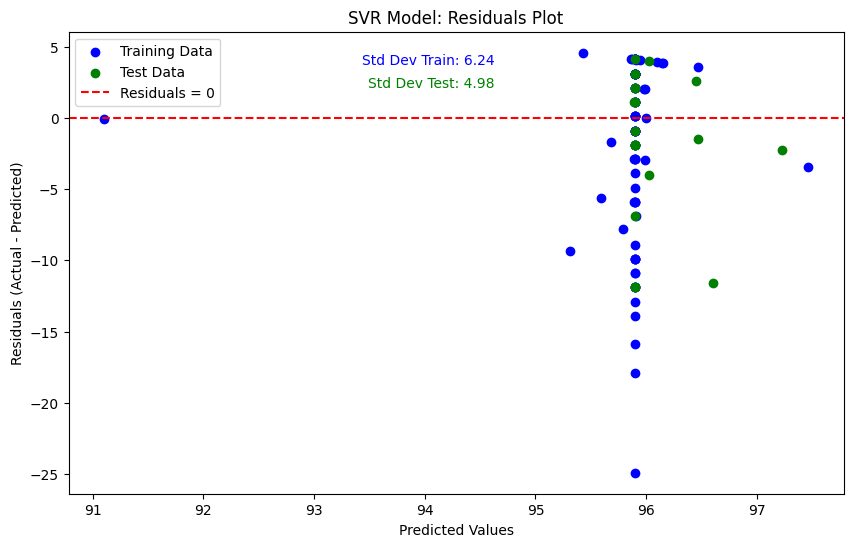

In [50]:
plt.figure(figsize=(10, 6))

# Calculate residuals for both training and test sets
residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred

# Training set
plt.scatter(y_train_pred, residuals_train, color='blue', label='Training Data')

# Test set
plt.scatter(y_test_pred, residuals_test, color='green', label='Test Data')

# Calculate standard deviation of residuals
std_dev_train = np.std(residuals_train)
std_dev_test = np.std(residuals_test)

plt.title('SVR Model: Residuals Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.axhline(y=0, color='r', linestyle='--', label='Residuals = 0')

# Display standard deviation information
plt.text(0.55, 0.93, f'Std Dev Train: {std_dev_train:.2f}', transform=plt.gca().transAxes, color='blue', ha='right')
plt.text(0.55, 0.88, f'Std Dev Test: {std_dev_test:.2f}', transform=plt.gca().transAxes, color='green', ha='right')

plt.legend()
plt.show()


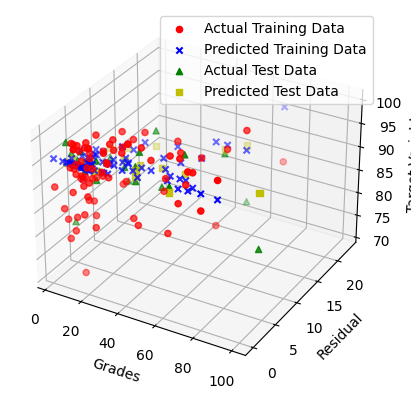

In [51]:
# 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for training data
ax.scatter(X_train[:, 0], X_train[:, 1], y_train, c='r', marker='o', label='Actual Training Data')

# Scatter plot for predicted values on training data
ax.scatter(X_train[:, 0], X_train[:, 1], y_train_pred, c='b', marker='x', label='Predicted Training Data')

# Scatter plot for testing data
ax.scatter(X_test[:, 0], X_test[:, 1], y_test, c='g', marker='^', label='Actual Test Data')

# Scatter plot for predicted values on testing data
ax.scatter(X_test[:, 0], X_test[:, 1], y_test_pred, c='y', marker='s', label='Predicted Test Data')

ax.set_xlabel('Grades')
ax.set_ylabel('Residual')
ax.set_zlabel('Target Variable')

plt.legend()
plt.show()

# **NEURAL NETWORK**

In [52]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Build a simple neural network
model = Sequential()
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

# Make predictions on both training and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate Mean Squared Error
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f'MSE on training data: {mse_train}')
print(f'MSE on test data: {mse_test}')


Epoch 1/10
6/6 [==============================] - 1s 68ms/step - loss: 4579625472.0000 - val_loss: 3819021568.0000
Epoch 2/10
6/6 [==============================] - 0s 18ms/step - loss: 1642366464.0000 - val_loss: 731821632.0000
Epoch 3/10
6/6 [==============================] - 0s 12ms/step - loss: 243627296.0000 - val_loss: 3253180.5000
Epoch 4/10
6/6 [==============================] - 0s 17ms/step - loss: 17932396.0000 - val_loss: 173469744.0000
Epoch 5/10
6/6 [==============================] - 0s 16ms/step - loss: 123946960.0000 - val_loss: 294279232.0000
Epoch 6/10
6/6 [==============================] - 0s 14ms/step - loss: 144814208.0000 - val_loss: 170975712.0000
Epoch 7/10
6/6 [==============================] - 0s 11ms/step - loss: 52959916.0000 - val_loss: 26235920.0000
Epoch 8/10
6/6 [==============================] - 0s 11ms/step - loss: 4575647.5000 - val_loss: 2530600.0000
Epoch 9/10
6/6 [==============================] - 0s 12ms/step - loss: 8682501.0000 - val_loss: 191365

In [53]:
# NEURAL NETWORK IMPLEMENTATION

from sklearn.neural_network import MLPRegressor

# Create the base decision tree regressor
bregressor = DecisionTreeRegressor(random_state=42, criterion='squared_error', max_depth=5)

# Create the bagging regressor
bagging_regressor_tree = BaggingRegressor(bregressor, n_estimators=8, random_state=42)

# Create the neural network regressor with a smaller architecture
nn_regressor = MLPRegressor(hidden_layer_sizes=(1,), max_iter=10, random_state=42)

# Concatenate the training and test sets for cross-validation
X_combined = np.concatenate((X_train, X_test), axis=0)
y_combined = np.concatenate((y_train, y_test), axis=0)

# Perform cross-validation with Bagging Regressor
cv_scores_tree = cross_val_score(bagging_regressor_tree, X_combined, y_combined, cv=5, scoring='neg_mean_squared_error')

# Perform cross-validation with Neural Network
cv_scores_nn = cross_val_score(nn_regressor, X_combined, y_combined, cv=5, scoring='neg_mean_squared_error')

# Fit the bagging regressor on the entire training set
bagging_regressor_tree.fit(X_train, y_train)

# Fit the neural network on the entire training set
nn_regressor.fit(X_train, y_train)

# Prediction with Bagging Regressor
y_train_pred_tree = bagging_regressor_tree.predict(X_train)
y_test_pred_tree = bagging_regressor_tree.predict(X_test)

# Prediction with Neural Network
y_train_pred_nn = nn_regressor.predict(X_train)
y_test_pred_nn = nn_regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE) for Bagging Regressor
print("Bagging Regressor MSE Train:", mean_squared_error(y_train, y_train_pred_tree))
print("Bagging Regressor MSE TEST:", mean_squared_error(y_test, y_test_pred_tree))

# Calculation of Mean Squared Error (MSE) for Neural Network
print("Neural Network MSE Train:", mean_squared_error(y_train, y_train_pred_nn))
print("Neural Network MSE TEST:", mean_squared_error(y_test, y_test_pred_nn))

# Print cross-validation scores for Bagging Regressor
print("Bagging Regressor Cross-Validation MSE Scores:", -cv_scores_tree)

# Print mean cross-validation MSE for Bagging Regressor
print("Bagging Regressor Mean Cross-Validation MSE:", -np.mean(cv_scores_tree))

# Print cross-validation scores for Neural Network
print("Neural Network Cross-Validation MSE Scores:", -cv_scores_nn)

# Print mean cross-validation MSE for Neural Network
print("Neural Network Mean Cross-Validation MSE:", -np.mean(cv_scores_nn))

# Print R2 scores for Bagging Regressor
print("Bagging Regressor R2 Train:", r2_score(y_train, y_train_pred_tree))
print("Bagging Regressor R2 TEST:", r2_score(y_test, y_test_pred_tree))

# Print R2 scores for Neural Network
print("Neural Network R2 Train:", r2_score(y_train, y_train_pred_nn))
print("Neural Network R2 TEST:", r2_score(y_test, y_test_pred_nn))


Bagging Regressor MSE Train: 9.953597880322578
Bagging Regressor MSE TEST: 40.056665568582574
Neural Network MSE Train: 1061395374.5923079
Neural Network MSE TEST: 1738445259.456051
Bagging Regressor Cross-Validation MSE Scores: [44.17333198 42.25597014 36.58591281 25.03626354 42.18004709]
Bagging Regressor Mean Cross-Validation MSE: 38.04630511231237
Neural Network Cross-Validation MSE Scores: [9.62522835e+08 1.06330780e+09 1.42764404e+09 7.41567817e+08
 1.82536206e+09]
Neural Network Mean Cross-Validation MSE: 1204080910.0367336
Bagging Regressor R2 Train: 0.7466550809224036
Bagging Regressor R2 TEST: -0.6389858522680383
Neural Network R2 Train: -27015268.103548396
Neural Network R2 TEST: -71131411.08202992


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum ite